**************************************************
其他
    建物型態 Yearmonth           單價元坪
70    其他   2020-10  127883.155864
71    其他   2020-11  146107.499627
72    其他   2020-12  129695.665979
73    其他   2021-01  130424.591894
74    其他   2021-02  135001.810396
75    其他   2021-03  126605.615888
76    其他   2021-04  123206.449295
77    其他   2021-05  119172.917389
78    其他   2021-06  104825.258444
79    其他   2021-07  102693.672064
80    其他   2021-08  106472.695619
81    其他   2021-09  129477.370890
82    其他   2021-10  120482.014802
83    其他   2021-11  135352.152713
84    其他   2021-12  133710.420858
85    其他   2022-01  134189.768222
86    其他   2022-02  125230.101275
87    其他   2022-03  134725.082741
88    其他   2022-04  120559.430657
89    其他   2022-05  145808.860220
90    其他   2022-06  149719.693081
91    其他   2022-07  135281.664332
92    其他   2022-08  102835.705956
93    其他   2022-09  124974.476539
94    其他   2022-10  129805.408674
95    其他   2022-11  112970.857402
96    其他   2022-12  120978.0

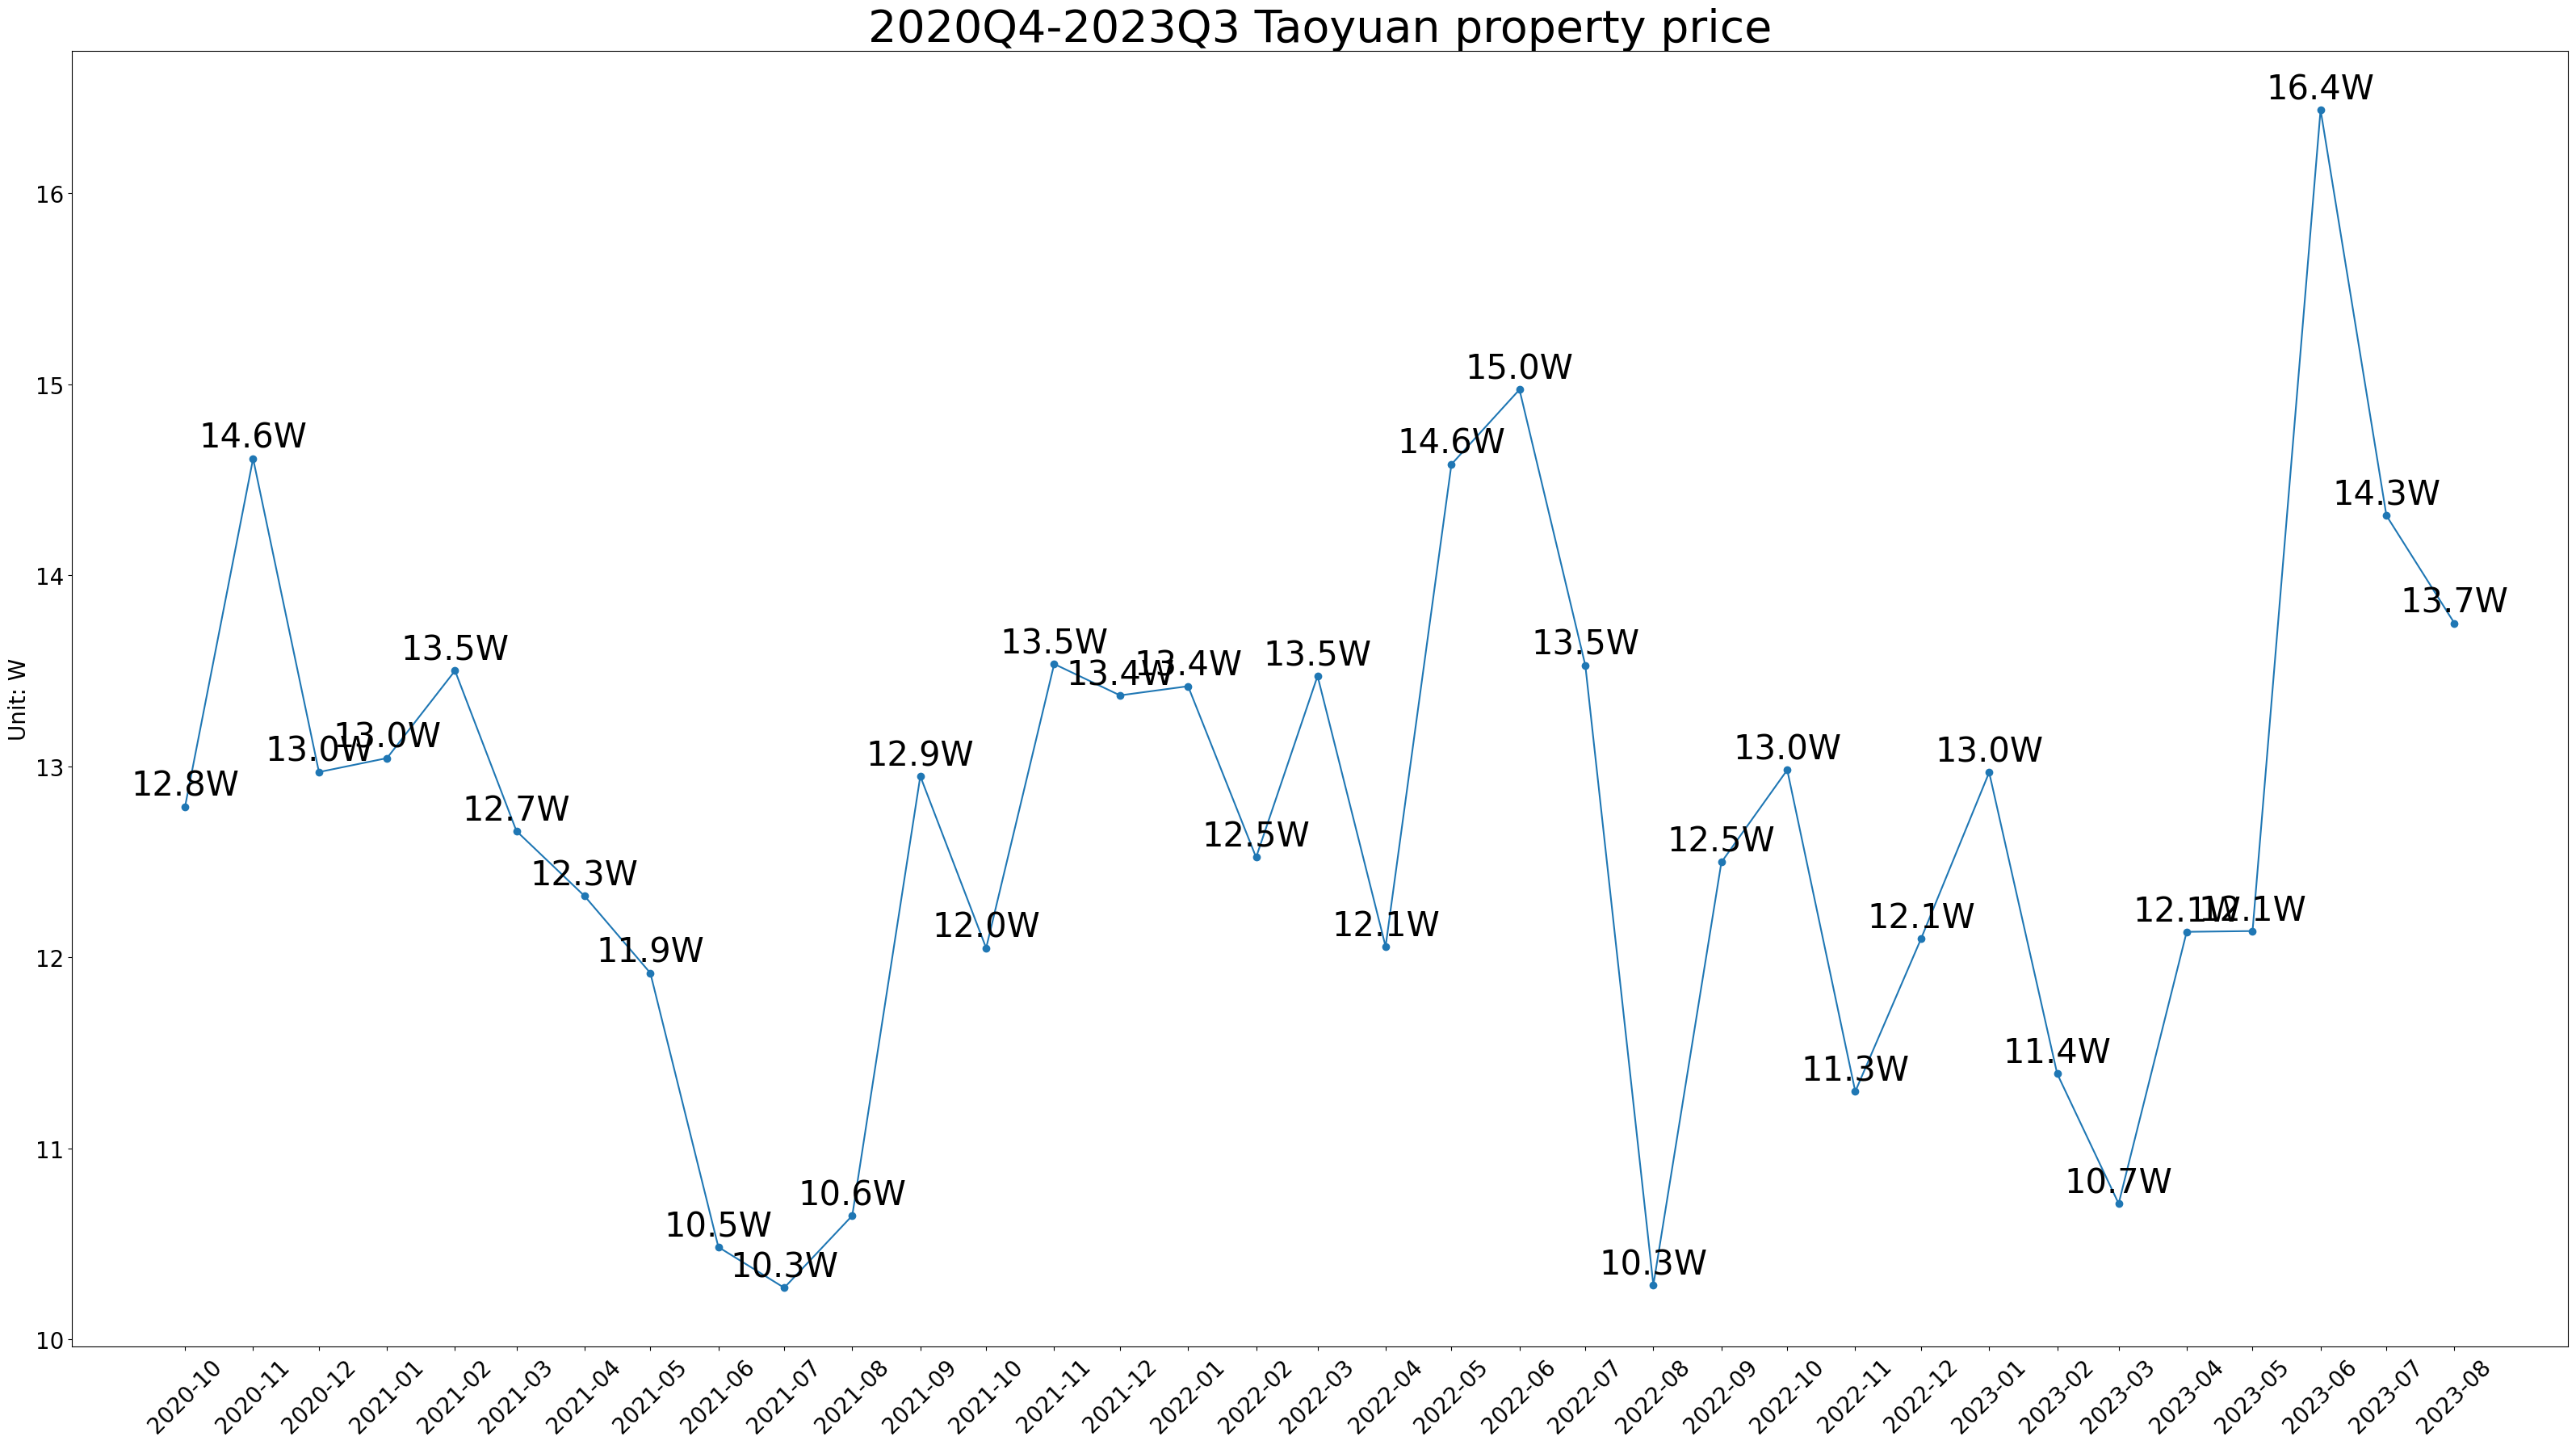

**************************************************
住宅大樓(11層含以上有電梯)
Empty DataFrame
Columns: [建物型態, Yearmonth, 單價元坪]
Index: []


ValueError: x and y must have same first dimension, but have shapes (35,) and (0,)

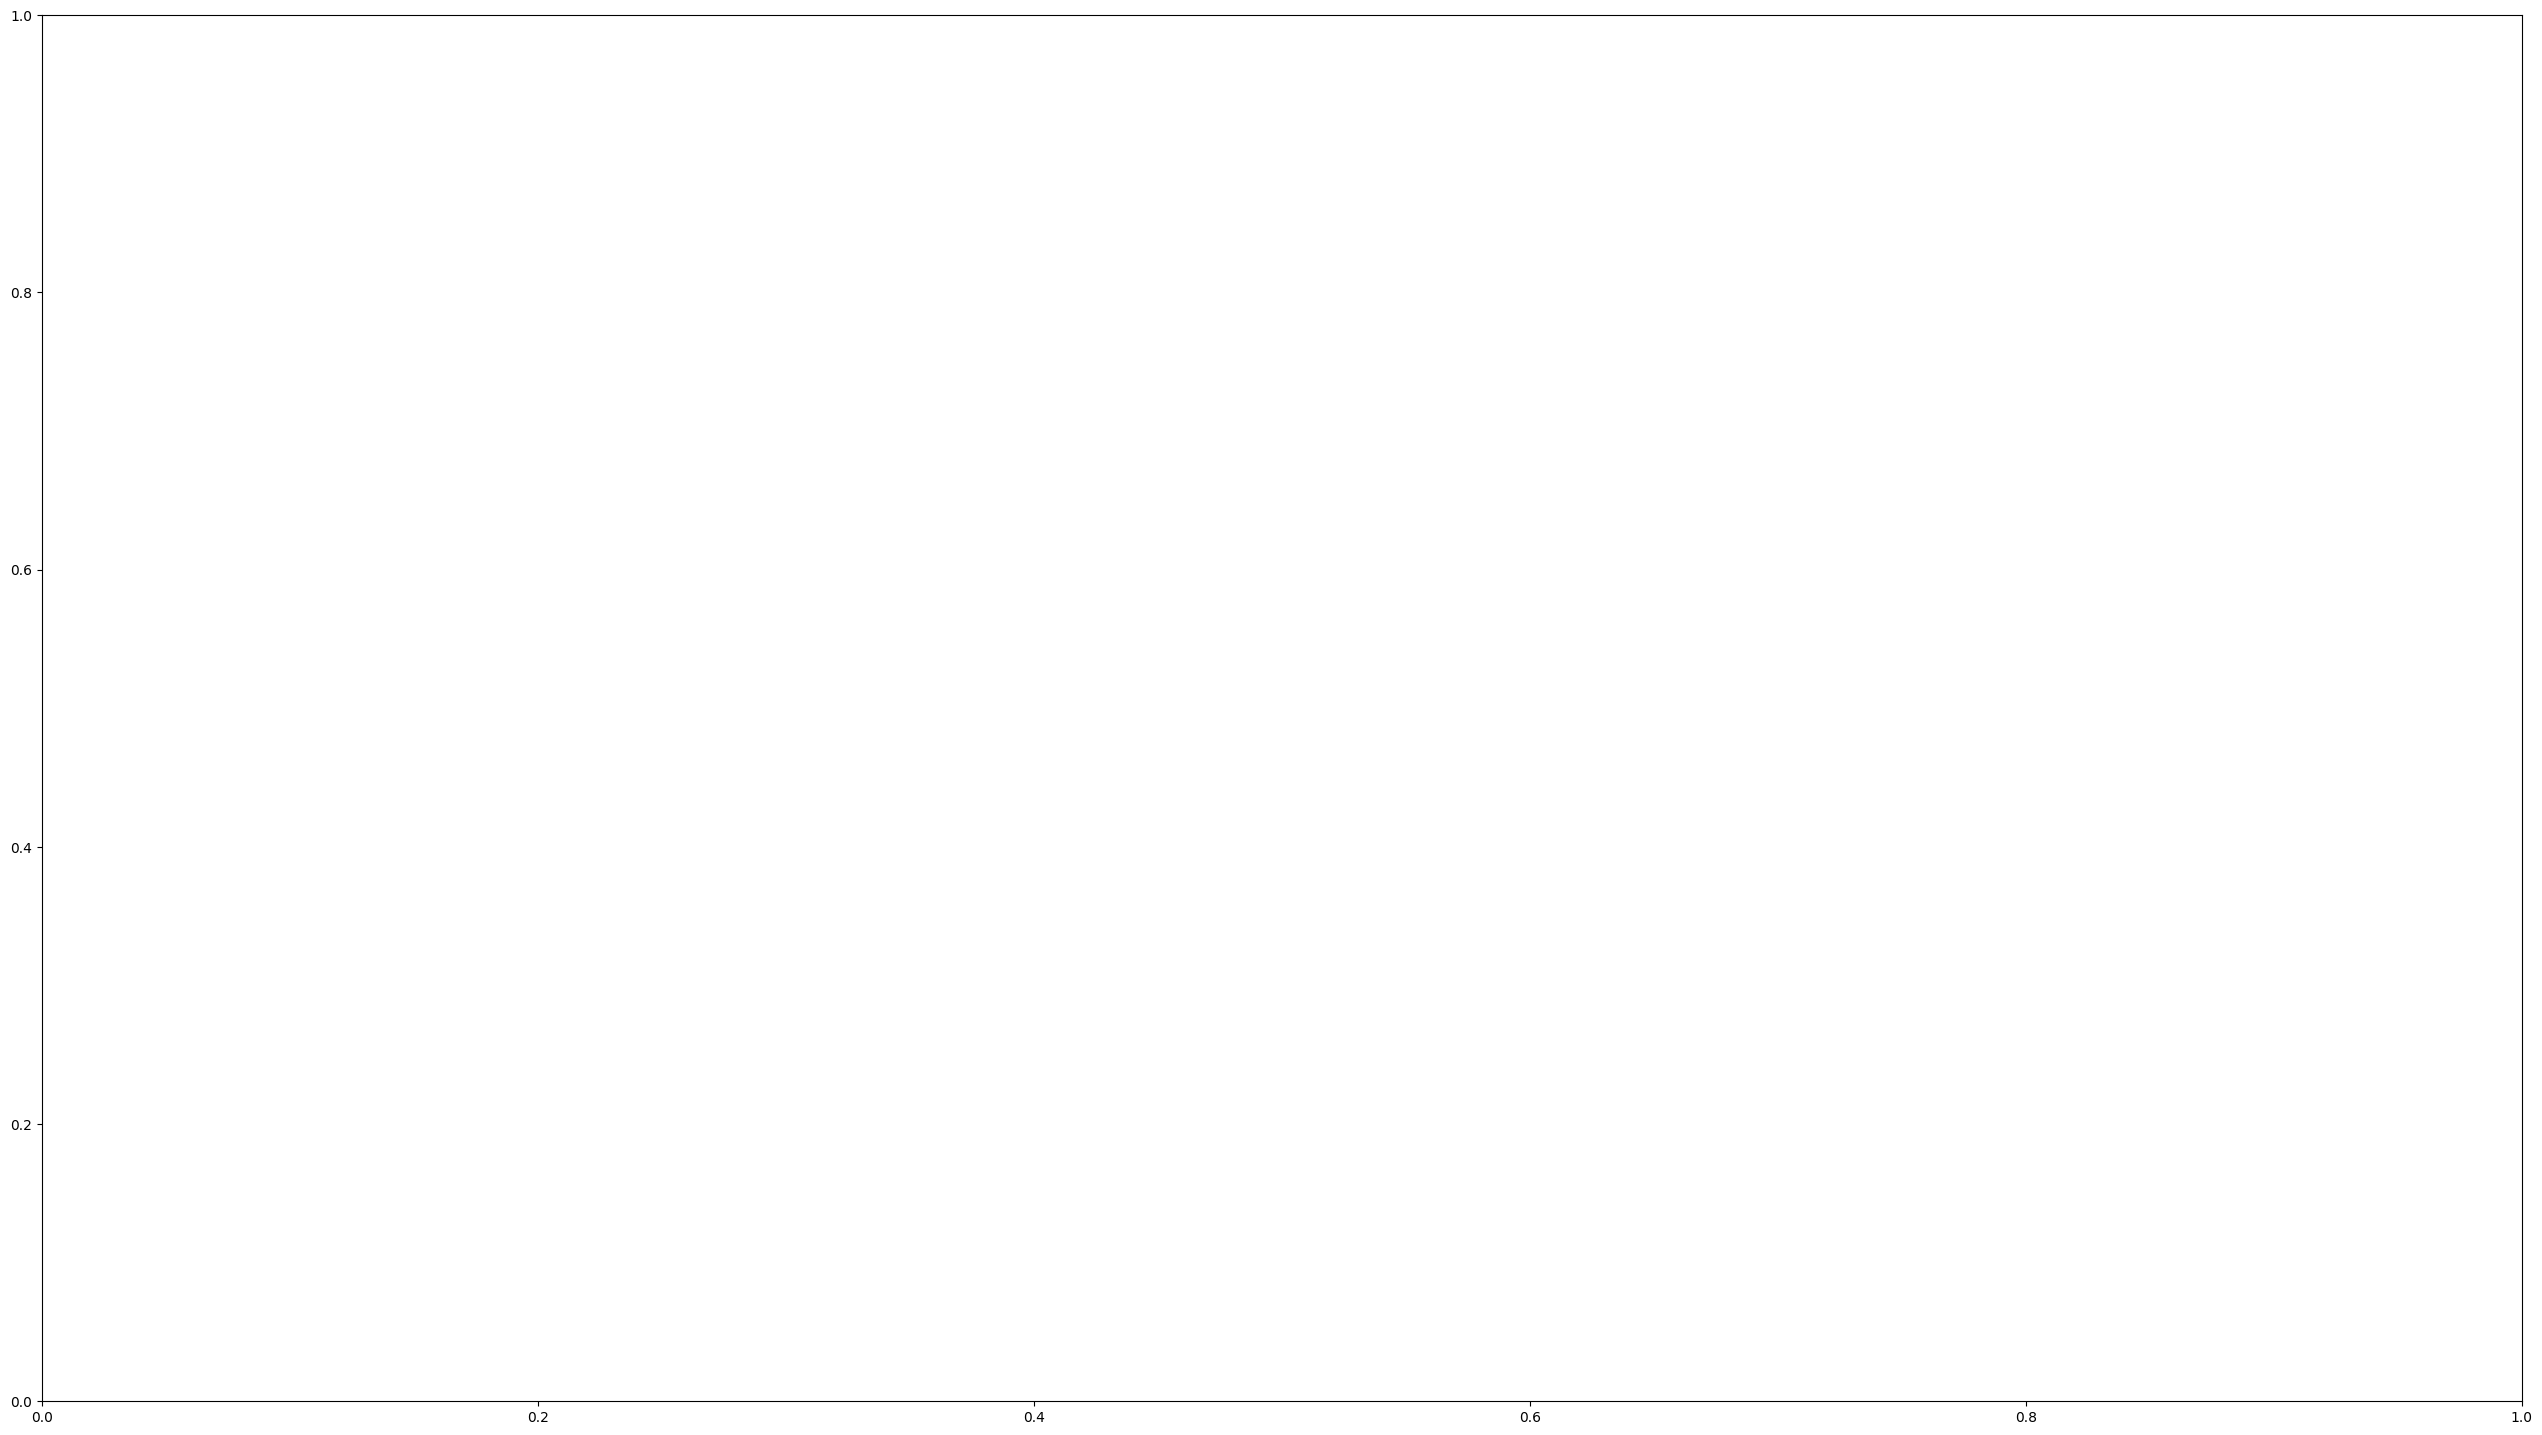

In [3]:
from pathlib import Path
import pandas as pd
from datetime import datetime

#use concat to merge all of files together
list_stacked = pd.DataFrame() 
current_path = Path()/'CSV'
for folder in current_path.absolute().glob('*'):
    for file in folder.glob('H_lvr_land_A.csv'):
        data = pd.read_csv(file)[1:]
        list_stacked = pd.concat([list_stacked, data])

#----------------------------------------------------------------------------------------------------------------------------
#Originally, there are 33 columns in the file; select 18 columns which need to be analyzed
data = list_stacked[['鄉鎮市區', '土地位置建物門牌', '土地移轉總面積平方公尺', '交易年月日', '總樓層數', '建物型態', '建物移轉總面積平方公尺', '總價元',
                     '單價元平方公尺', '主建物面積']]

#----------------------------------------------------------------------------------------------------------------------------
#坪 is the most popular unit that Taiwanese to measure the property, so we need to transfer from meter squared to 坪
data = data.copy()
data = data[data['鄉鎮市區'].notna()]
data['土地移轉總面積坪'] = data['土地移轉總面積平方公尺'].astype(float)*3.3058
data['建物移轉總面積坪'] = data['建物移轉總面積平方公尺'].astype(float)*3.3058
data['單價元坪'] = data['單價元平方公尺'].astype(float)*3.3058
data['主建物面積'] = data['主建物面積'].astype(float)*3.3058
data['總價元'] = data['總價元'].astype(float)
data['交易年月日'] = pd.to_datetime((data['交易年月日'].astype(int)+19110000).astype(str), format = '%Y%m%d', errors='coerce') #轉換成日期型態
condition = (data['交易年月日'] >= '2020-10-01') & (data['交易年月日'] <= '2023-09-30') # 篩選資料，只篩選過去36個月的資料
data = data[condition]

data['Year'] = data['交易年月日'].dt.year.fillna(0).astype(int)
data['Quarter'] = data['交易年月日'].dt.quarter.fillna(0).astype(int)
data['Month'] = data['交易年月日'].dt.month.fillna(0).astype(int).map("{:02}".format)
data['Day'] = data['交易年月日'].dt.day.fillna(0).astype(int)

# # #----------------------------------------------------------------------------------------------------------------------------

data = data.where(pd.notnull(data), None)
# filter_dist = list(set(data['鄉鎮市區']))

# # # #----------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
import numpy as np

lst = []
for year, month in zip(data['Year'],data['Month']):
    lst.append('-'.join(str(i) for i in [year, month]))
data['Yearmonth'] = lst
data['Yearmonth'] = pd.to_datetime(data['Yearmonth'], format = '%Y-%m').dt.to_period('M')

# for i in filter_dist:
#     print(i)
#     y = data.groupby(['鄉鎮市區', 'Yearmonth'])['單價元坪'].mean()
#     # y = list(data.groupby('Yearmonth','鄉鎮市區')['單價元坪'].mean())#.apply(lambda x: (x == i).mean()).reset_index(name='test'))
#     # y_values = [int(i)/10000 for i in y]
#     print(y)

data2 = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
property_type = list(set(data2['建物型態']))
# {'公寓(5樓含以下無電梯)', '廠辦', '其他', '透天厝', '店面(店鋪)', '工廠', '住宅大樓(11層含以上有電梯)', '華廈(10層含以下有電梯)'}

for item in property_type:

    x_values = sorted(set(lst))
    dates = [datetime.strptime(date, '%Y-%m') for date in x_values]
    # Convert datetime objects to numerical values
    x_values_numeric = date2num(dates)

    data2 = data2[data2['建物型態'] == item]
    print('*'*50)
    print(item)
    print(data2)
    plt.figure(figsize=(32, 18))

    # Convert date strings to datetime objects
    dates = [datetime.strptime(date, '%Y-%m') for date in x_values]

    y = list(data2.groupby(['Yearmonth'])['單價元坪'].mean())
    y_values = [int(i)/10000 for i in y]

    # # # # #----------------------------------------------------------------------------------------------------------------------------
    # Perform linear regression to get the trendline
    # coefficients = np.polyfit(x_values_numeric, y_values, 1)
    # trendline = np.polyval(coefficients, x_values_numeric)

    # Create the line chart
    plt.plot(x_values_numeric, y_values, marker='o')#, label='Your Data'
    # plt.plot(x_values_numeric, trendline, label='Trendline', linestyle='--', color='red')

    # Set the x-axis ticks to be the original date strings
    plt.xticks(x_values_numeric, x_values, rotation=45)

    # Add labels and title
    # plt.xlabel('Date')
    plt.xticks(fontsize=20, rotation=45)
    plt.ylabel('Unit: W', fontsize = 20)
    plt.yticks(fontsize=20)
    plt.title("2020Q4-2023Q3 Taoyuan property price", fontsize = 40)

    # Annotate the data points
    for i, txt in enumerate(y_values):
        plt.annotate(f'{txt:.1f}W', (x_values_numeric[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', size = 30)

    # Adjust layout to prevent label overlap
    plt.tight_layout()

    # Show the chart
    plt.show()

    # # # #----------------------------------------------------------------------------------------------------------------------------
    df = pd.DataFrame({'Date': x_values, 'Price': y_values})
    df['Price'] = df['Price'].round(1)
    df.transpose()